# Trip analysis

This notebook intends to analyze a shooping trip analysis dataset and create an ML algorithm to predict consumer cateogries based on trip consumption analysis


## 1. Column analysis

Lets analyze the dataset columns. We have the following

- `TripType`- a categorical id representing the type of shopping trip the customer made. This is the  ground truth that you are predicting. TripType ‘999’ is an "other" category
- `VisitNumber` - an id corresponding to a single trip by a single customer; 
- `Weekday` - the weekday of the trip; 
- `Upc` - the UPC number of the product purchased; 
- `ScanCount` - the number of the given item that was purchased. A negative value indicates a product  return; 
- `DepartmentDescription` - a high-level description of the item's department; 
- `FinelineNumber` - a more refined category for each of the products. 

In [99]:
import pandas as pd

data = pd.read_csv('data/train2026.csv')
print("Data shape: ",data.shape)
data.head()

Data shape:  (517473, 7)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,40,163599,Wednesday,7.940001e+09,3,PERSONAL CARE,5030.0
1,40,163599,Wednesday,7.366589e+10,2,PERSONAL CARE,5122.0
2,40,163599,Wednesday,6.833332e+10,1,PERSONAL CARE,9111.0
3,40,163599,Wednesday,4.145776e+09,1,PERSONAL CARE,5116.0
4,40,163599,Wednesday,7.940024e+09,2,PERSONAL CARE,5030.0


### 1.1 TripType 

Lets investigate the distribuition of TripType our predictor column 

Number of elements - 38


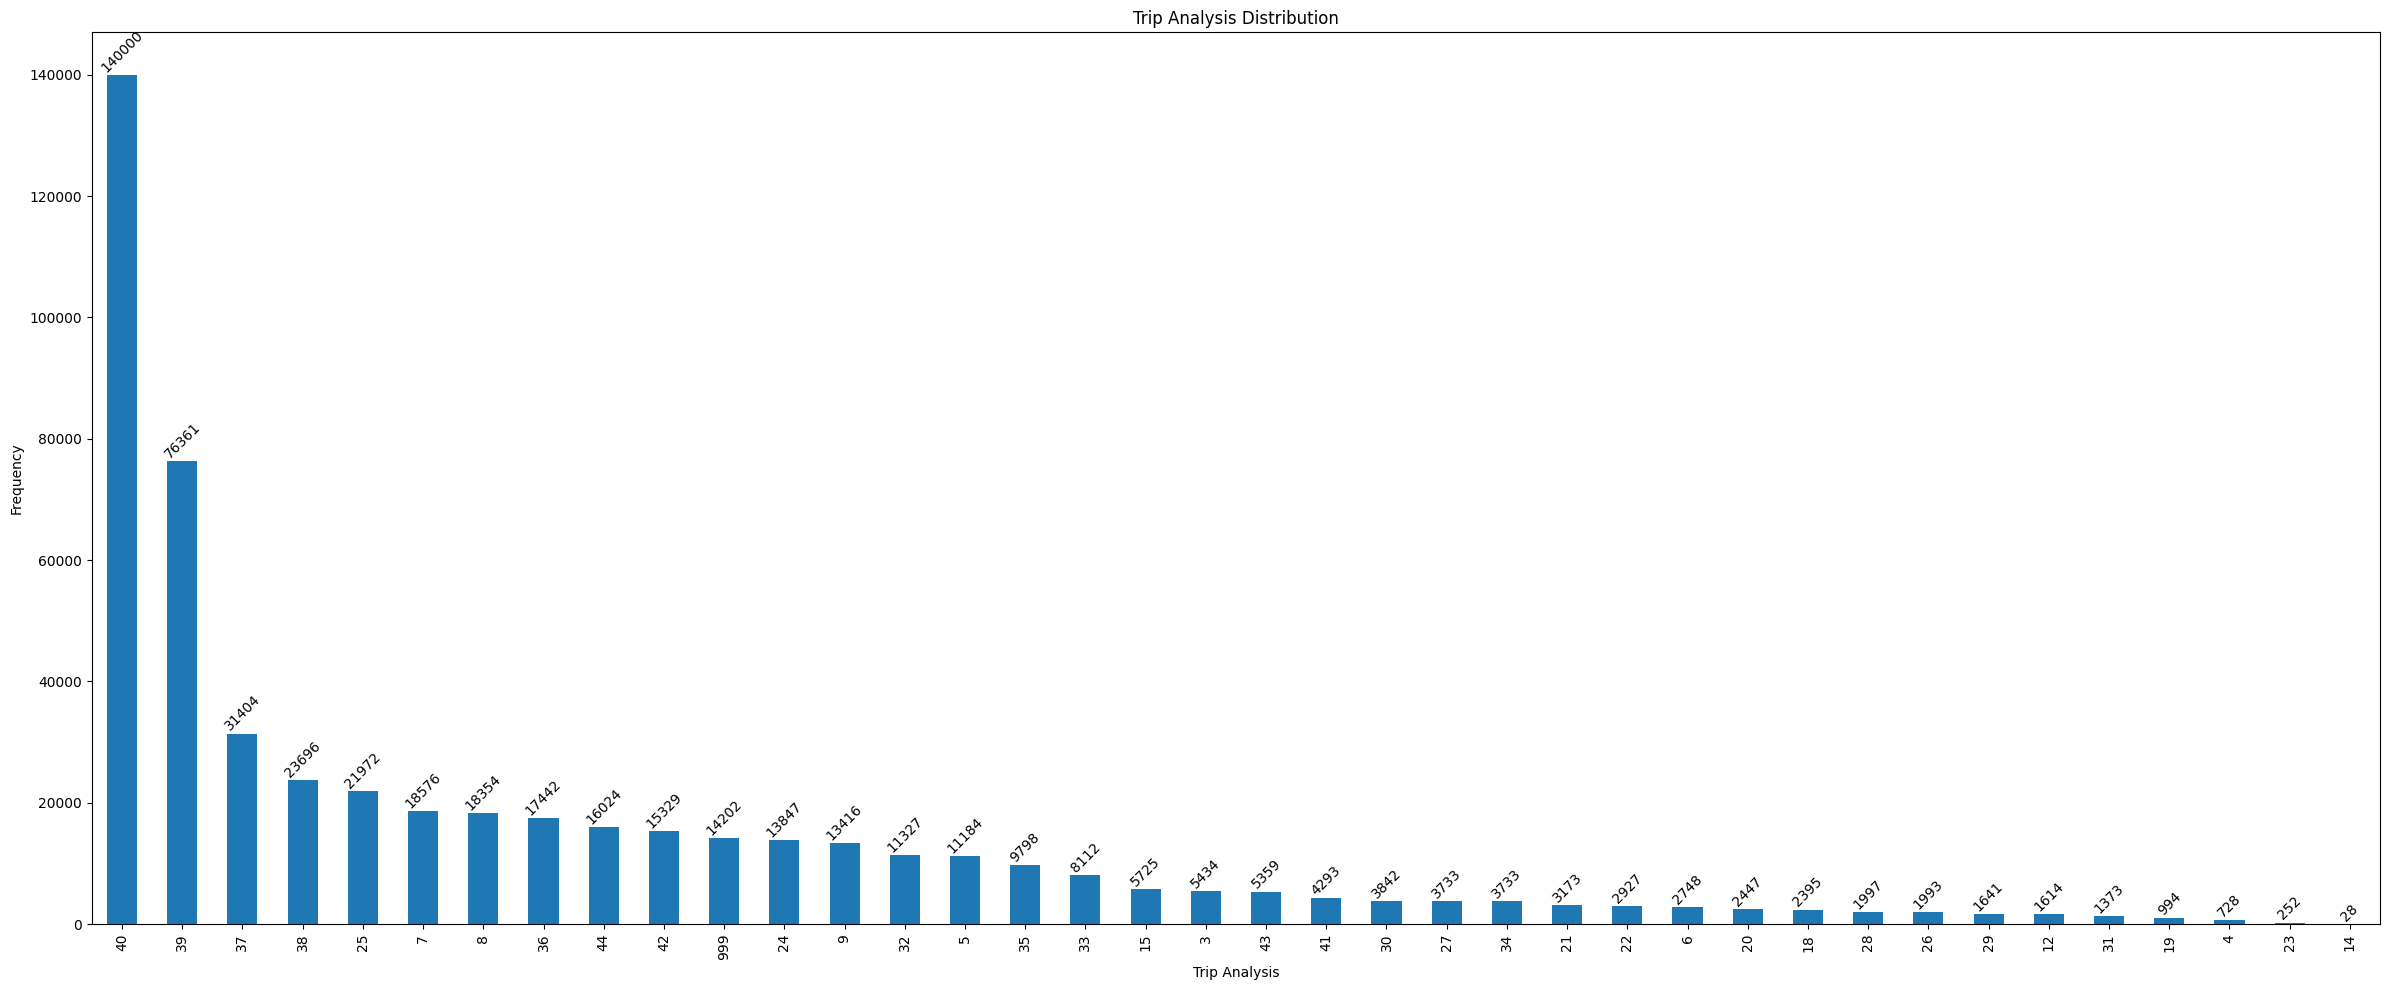

In [100]:
import matplotlib.pyplot as plt

print("Number of elements -",len(data.TripType.unique()))

ax = data.TripType.value_counts(dropna=False).plot.bar(
    figsize=(24,10),
    title='Trip Analysis Distribution'
)

# Add value labels
for i, v in enumerate(data.TripType.value_counts(dropna=False)):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10,rotation=45)

plt.xticks(rotation=90)
plt.xlabel("Trip Analysis")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

The target column looks pretty unbalanced. We will need to tackle this issue when creating our prediction algorithm either with:
- using algorithms tha deal with this issue 
- over/under sample in order to have more/less examples 

It also does not present any `null`/`nan` values

### 1.2 VisitNumber

The column VisitNumber is a column that represents a trip to the supermarket. It is baiscally our primary key. This will be used to group all the trip records into a single one. 

In [101]:
# Our final dataset will have something around 76605 records (might discard some rows during preprocess)
print("Number of elements - ",len(data.VisitNumber.unique()))

Number of elements -  76605


### 1.3 Weekday

Weekday column should be encoded (for example using cyclical function) and new features can be derived from it (is_weekend, is_weekday, paycheck_proximity..). This column also will help us understanding what are the consumer habits and in which days people go more to the store

In [102]:
print(f"Number of nans/nulls - {data.Weekday.isna().sum()}")
data.Weekday.value_counts()

Number of nans/nulls - 0


Weekday
Sunday       104555
Saturday      89807
Friday        72054
Monday        62828
Wednesday     57141
Tuesday       55902
Thursday      48186
SATURDAY       7000
THURSDAY       6000
FrIdAy         5000
MonDAY         4000
sunday         3000
tuesday        2000
Name: count, dtype: int64

We also will need to standardize the presented values - lowercase, trim, etc

### 1.4 Upc

Column Upc has all the items purchased in per store trip. It might be used for one-hot-encoding when aggregated by trip, but since it has high cardinality we will need to investigate since other columns describing the product might be used and enough. We might also use it with `ScanCount` and use with a CountVectorizer approach.

It also presents some nans that might be discarded from the data. The values range are also very big, so despite being a categorical column, we might encode those to improve readability 

In [103]:
print(f'Number of elements - Upc {len(data.Upc.unique())}')
print(f"Number of nans/nulls - {data.Upc.isna().sum()}")
print(f"Max number - {data.Upc.max()}")
print(f"Min number - {data.Upc.min()}")

Number of elements - Upc 85895
Number of nans/nulls - 3331
Max number - 978971000000.0
Min number - 834.0


### 1.5 ScanCount

Column ScanCount will be summed across trip grouby to get number of products purchased every trip. 

In [104]:
print(f"Number of nan - {data.ScanCount.isna().sum()}")
print(f"Max number - {data.ScanCount.max()}")
print(f"Min number - {data.ScanCount.min()}")

# ^-?     -> optional minus sign at the start
# \d+     -> one or more digits
# $       -> end of the string
# This also prevents from catching floats  - we can't have 1.5 products being returned
regex_is_digit = r'^-?\d+$'
print(f"Are all values digits - {data.ScanCount.astype(str).str.match(regex_is_digit).all()}")

print("\nDistribuition of returned products:")
data[data.ScanCount<1].ScanCount.value_counts()

Number of nan - 0
Max number - 51
Min number - -10
Are all values digits - True

Distribuition of returned products:


ScanCount
-1     11572
-2       639
-3       105
-4        57
-5        13
-6         9
-9         2
-10        1
-7         1
Name: count, dtype: int64

### 1.6 Department description 

This column will need to be cleaned and encoded - lowercase, trimmed in order to standardize values. 

There are also some Nans that might be removed. There are also some columns that might be joined together for example MENS WEAR together with MENSWEAR

In [105]:
print(f'Number of nans - {data.DepartmentDescription.isna().sum()}')

data.DepartmentDescription.value_counts()

Number of nans - 1086


DepartmentDescription
GROCERY DRY GOODS         53067
DSD GROCERY               51255
PRODUCE                   37411
DAIRY                     31609
PERSONAL CARE             30016
                          ...  
LARGE HOUSEHOLD GOODS        57
CONCEPT STORES               29
OTHER DEPARTMENTS            25
SEASONAL                     23
HEALTH AND BEAUTY AIDS        2
Name: count, Length: 99, dtype: int64

### 1.7 FineLineNumber

FineLine number. Nans should be cleaned

In [106]:
print(f'Number of nans - {data.FinelineNumber.isna().sum()}')
data.FinelineNumber.value_counts()

Number of nans - 3331


FinelineNumber
5501.0    6608
1508.0    4133
135.0     3615
808.0     3561
0.0       3061
          ... 
5358.0       1
3916.0       1
8554.0       1
2289.0       1
5668.0       1
Name: count, Length: 5126, dtype: int64

## 2. Preprocessing
Preprocess data for training the model

### 2.1 Taking care of text categorical features
Clean categorical text features

In [107]:
import numpy as np
import re

data_cleaned = pd.DataFrame(data)

# Function for standardization
def standardize_text_categories(cat:str) -> str:
    """Standardizes given text

    Args:
        cat (str): category to be standardize

    Returns:
        standardize text
    """
    return re.sub(r'[^a-zA-Z]', '', cat.strip().lower()) # remove non-letters

# Weekday
# Remove nans. Encoding done later 
data_cleaned['Weekday']=data_cleaned['Weekday'].apply(lambda x: standardize_text_categories(x))
print("Weekday values -",data_cleaned['Weekday'].unique().tolist())


# DepartmentDescription
# Remove nans
data_cleaned = data_cleaned.dropna(subset=['DepartmentDescription'])

# standardize and fix category
data_cleaned['DepartmentDescription'] = data_cleaned['DepartmentDescription'].apply(lambda x: standardize_text_categories(x))

print("Number of department description -",data_cleaned['DepartmentDescription'].nunique())
print(data_cleaned.shape)
data_cleaned.head()

Weekday values - ['wednesday', 'tuesday', 'sunday', 'monday', 'friday', 'thursday', 'saturday']
Number of department description - 67
(516387, 7)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,40,163599,wednesday,7.940001e+09,3,personalcare,5030.0
1,40,163599,wednesday,7.366589e+10,2,personalcare,5122.0
2,40,163599,wednesday,6.833332e+10,1,personalcare,9111.0
3,40,163599,wednesday,4.145776e+09,1,personalcare,5116.0
4,40,163599,wednesday,7.940024e+09,2,personalcare,5030.0


### 2.2 Aggregating by visit with count

We want to aggregate by visit and use Upc as dummies but with count per product. Also we will create a total ScanCount of the store trip

In [108]:
visit_agg = data_cleaned[['VisitNumber','TripType','Weekday','ScanCount']].groupby(['VisitNumber','Weekday'],as_index=False).sum()
visit_agg=visit_agg.set_index('VisitNumber').rename(columns={"ScanCount":"Total"}) # set index to VisitNumber to be able to join and rename ScanCount
visit_agg

,Weekday,TripType,Total
VisitNumber,,,
8,friday,572,27
11,friday,140,4
12,friday,287,7
15,friday,168,9
19,friday,378,9
...,...,...,...
191335,sunday,288,9
191343,sunday,175,9
191344,sunday,110,5


Creating now a pivot matrix for Upc and ScanCount using `fastpivot`- https://pypi.org/project/fastpivot/

In [109]:
from fastpivot import pivot_sparse

pivot_upc=pivot_sparse(data_cleaned, index='VisitNumber', columns='Upc', values='ScanCount', fill_value=0).fillna(0)
pivot_upc

Upc,8.340000e+02,3.032000e+03,3.035000e+03,3.066000e+03,3.082000e+03,3.100000e+03,3.107000e+03,3.112000e+03,3.121000e+03,3.127000e+03,...,9.781590e+11,9.781600e+11,9.781610e+11,9.781620e+11,9.781630e+11,9.781850e+11,9.781940e+11,9.782760e+11,9.789680e+11,9.789710e+11
VisitNumber,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# investigating a single record
row = pivot_upc.loc[163599]
row[(row != 0)].to_dict()

{3080000054.0: 1,
 3500000163.0: 1,
 3650009396.0: 2,
 3700035155.0: 1,
 4145712309.0: 1,
 4145776015.0: 1,
 4178599717.0: 1,
 4319416111.0: 1,
 7198074003.0: 1,
 7314918518.0: 1,
 7431974010.0: 1,
 7874203000.0: 1,
 7874204008.0: 2,
 7874204020.0: 5,
 7874205018.0: 1,
 7874205020.0: 1,
 7874209326.0: 1,
 7940000954.0: 3,
 7940023618.0: 2,
 8019638462.0: 6,
 68333321538.0: 1,
 73665891030.0: 2,
 88563180596.0: 1,
 88611170557.0: 1}

Now we need to merge both into a single dataframe. Since we preserved the VisitNumber we will do this by index

In [111]:
data_agg=visit_agg.join(pivot_upc, how='inner')
data_agg

,Weekday,TripType,Total,834.0,3032.0,3035.0,3066.0,3082.0,3100.0,3107.0,...,978159000000.0,978160000000.0,978161000000.0,978162000000.0,978163000000.0,978185000000.0,978194000000.0,978276000000.0,978968000000.0,978971000000.0
VisitNumber,,,,,,,,,,,,,,,,,,,,,
8,friday,572,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,friday,140,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,friday,287,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,friday,168,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,friday,378,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191335,sunday,288,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191343,sunday,175,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191344,sunday,110,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 Department description dummies

We will apply a similar methodology as before to department description but using the actual category frequency by visit

In [112]:
department_dummies = pd.get_dummies(
    data_cleaned.set_index('VisitNumber').DepartmentDescription,dtype=int,sparse=True
).groupby('VisitNumber').sum()
department_dummies

,accessories,automotive,bakery,bathandshower,beauty,bedding,booksandmagazines,boyswear,brasshapewear,camerasandsupplies,...,seafood,seasonal,servicedeli,sheerhosiery,shoes,sleepwearfoundations,sportinggoods,swimwearouterwear,toys,wireless
VisitNumber,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191344,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [113]:
# investigating a single record
row = department_dummies.loc[163599]
row[(row != 0)].to_dict()

{'candytobaccocookies': 1,
 'electronics': 2,
 'homemanagement': 1,
 'householdchemicalssupp': 5,
 'householdpapergoods': 5,
 'officesupplies': 3,
 'personalcare': 7,
 'pharmacyotc': 1}

merge with agg data

In [114]:
data_agg=data_agg.join(department_dummies, how='inner')
data_agg

,Weekday,TripType,Total,834.0,3032.0,3035.0,3066.0,3082.0,3100.0,3107.0,...,seafood,seasonal,servicedeli,sheerhosiery,shoes,sleepwearfoundations,sportinggoods,swimwearouterwear,toys,wireless
VisitNumber,,,,,,,,,,,,,,,,,,,,,
8,friday,572,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,friday,140,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,friday,287,7,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
15,friday,168,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,friday,378,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191335,sunday,288,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191343,sunday,175,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191344,sunday,110,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 2.4 Weekday encoding

Encoding weekday and deriving new features from it

In [126]:
DAY_MAPPING= {
    'monday': 1, 'tuesday': 2, 'wednesday': 3, 'thursday': 4, 
    'friday': 5, 'saturday': 6, 'sunday': 7
}

day_num = data_agg['Weekday'].map(DAY_MAPPING)

# Encode weekday into cyclical features
data_agg['weekday_sin'] = np.sin((2 * np.pi / 7)* day_num)
data_agg['weekday_cos'] = np.cos((2 * np.pi / 7)* day_num)

# check when we have a weekend
data_agg['is_weekend'] = data_agg['Weekday'].isin(['saturday', 'sunday']).astype(int)
data_agg = data_agg.drop('Weekday',axis=1)
data_agg

,TripType,Total,834.0,3032.0,3035.0,3066.0,3082.0,3100.0,3107.0,3112.0,...,sheerhosiery,shoes,sleepwearfoundations,sportinggoods,swimwearouterwear,toys,wireless,weekday_sin,weekday_cos,is_weekend
VisitNumber,,,,,,,,,,,,,,,,,,,,,
8,572,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-9.749279e-01,-0.222521,0
11,140,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-9.749279e-01,-0.222521,0
12,287,7,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,-9.749279e-01,-0.222521,0
15,168,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-9.749279e-01,-0.222521,0
19,378,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-9.749279e-01,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191335,288,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.449294e-16,1.000000,1
191343,175,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.449294e-16,1.000000,1
191344,110,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-2.449294e-16,1.000000,1


## 3. Modeling

Creating a model for predicting TripTypes